Driver script to import and pre-process the OASIS brain data.
Builds and trains the VQVAE model, generating images and SSIM accuracy of the test dataset.

@author Mallika Mukherji
@email m.mukherji@uqconnect.edu.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from vqvae_model import *
from pixelcnn import *

In [2]:
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


In [3]:
# Initialise paths for training, testing and validation sets
TRAIN_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_train"
TEST_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_test"
VAL_IMAGE_PATH = "D:\keras_png_slices_data\keras_png_slices_validate"

In [4]:
# Incitialise directories for training, testing and validation data
train_files = os.listdir(TRAIN_IMAGE_PATH)
test_files = os.listdir(TEST_IMAGE_PATH)
validate_files = os.listdir(VAL_IMAGE_PATH)

In [5]:
# Initialise image dimensions for model
IMG_HEIGHT = 80
IMG_WIDTH = 80

In [6]:
def load_images(path, image_files):
    """
    Returns a list of resized images at the given path.
    """
    images = []

    for file in image_files:
        image = Image.open(path + '/' + file) 
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image = np.reshape(image, (IMG_HEIGHT, IMG_WIDTH, 1))
        images.append(image)
        
    return images

In [7]:
# Load images into lists
train_images = load_images(TRAIN_IMAGE_PATH, train_files)
test_images = load_images(TEST_IMAGE_PATH, test_files)

In [8]:
# Convert lists into np arrays
x_train = np.array(train_images)
x_test = np.array(test_images)

In [9]:
# Pre-process the OASIS brain data.
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

# Calculate data variance
data_variance = np.var(x_train / 255.0)

# Check shapes of arrays
print(x_train.shape)
print(data_variance.shape)

(9664, 80, 80, 1)
()


In [10]:
# Display 
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Train Image', 'Test Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=plt.cm.gray)
        plt.axis('off')
    
    plt.show()

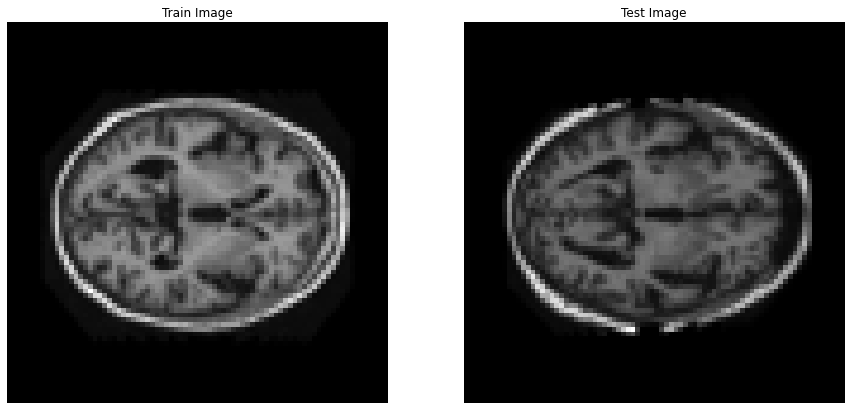

In [12]:
# Check dataset has been successfully loaded and pre-processed.
display([x_train_scaled[0], x_test_scaled[0]])

In [13]:
# Train the VQVAE model
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
76/76 [==============================] - 8s 31ms/step - loss: 2.9096 - reconstruction_loss: 1.5444 - vqvae_loss: 0.3730
Epoch 2/30
76/76 [==============================] - 2s 28ms/step - loss: 12.4977 - reconstruction_loss: 0.4101 - vqvae_loss: 12.0248 1s - loss: 14.8129 - reconstruction_loss
Epoch 3/30
76/76 [==============================] - 2s 28ms/step - loss: 2.6681 - reconstruction_loss: 0.3124 - vqvae_loss: 2.3475
Epoch 4/30
76/76 [==============================] - 2s 28ms/step - loss: 1.4081 - reconstruction_loss: 0.2922 - vqvae_loss: 1.1111
Epoch 5/30
76/76 [==============================] - 2s 28ms/step - loss: 0.9997 - reconstruction_loss: 0.2764 - vqvae_loss: 0.7203
Epoch 6/30
76/76 [==============================] - 2s 28ms/step - loss: 0.8304 - reconstruction_loss: 0.2675 - vqvae_loss: 0.5590
Epoch 7/30
76/76 [==============================] - 2s 28ms/step - loss: 0.8630 - reconstruction_loss: 0.2419 - vqvae_loss: 0.6150 1s - loss: 0.8755 - reconstr
Epoch 8/30


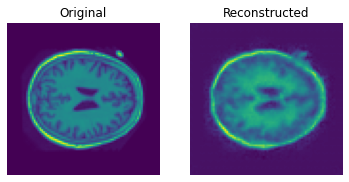

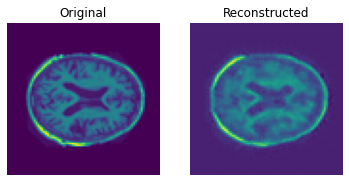

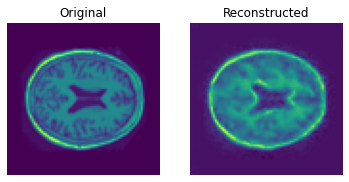

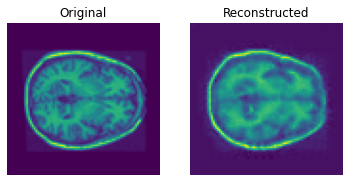

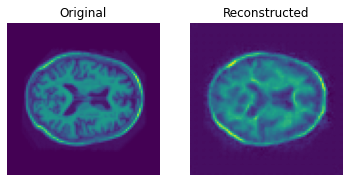

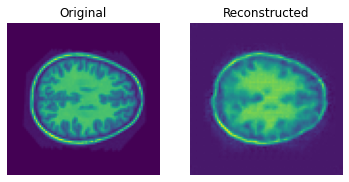

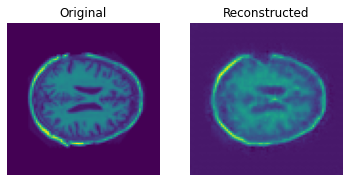

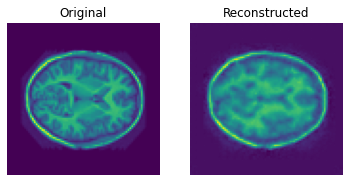

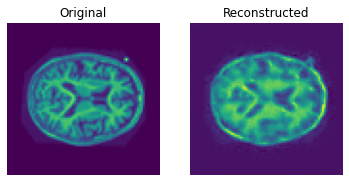

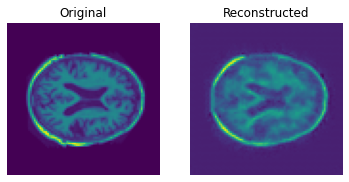

In [14]:
# Visualise reconstructions on the test set

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

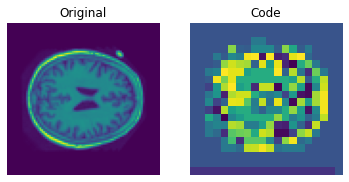

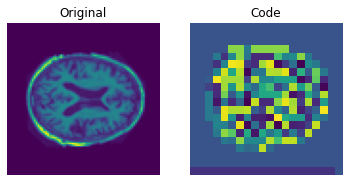

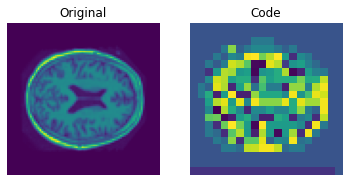

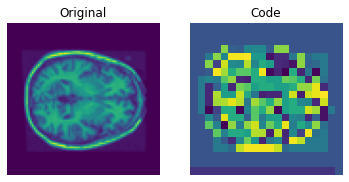

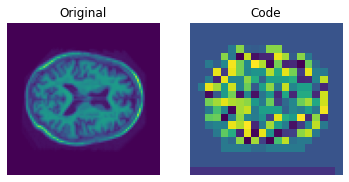

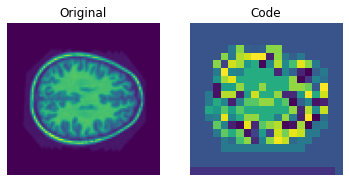

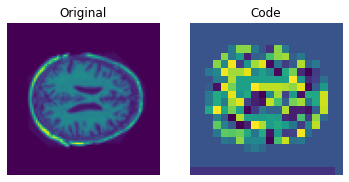

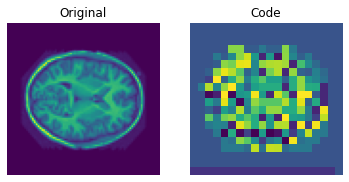

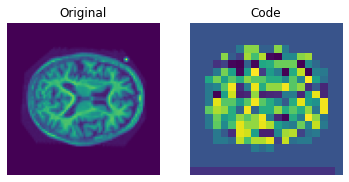

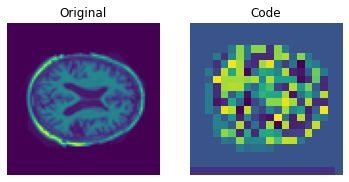

In [15]:
# Visualise the discrete codes

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [16]:
# Get the PixelCNN model

pixel_cnn = get_pixelcnn(vqvae_trainer, encoded_outputs)
pixel_cnn.summary()

Input shape of the PixelCNN: (20, 20)
Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 20)]          0         
_________________________________________________________________
tf.one_hot (TFOpLambda)      (None, 20, 20, 128)       0         
_________________________________________________________________
pixel_conv_layer (PixelConvL (None, 20, 20, 128)       802944    
_________________________________________________________________
residual_block (ResidualBloc (None, 20, 20, 128)       98624     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 20, 20, 128)       98624     
_________________________________________________________________
pixel_conv_layer_3 (PixelCon (None, 20, 20, 128)       16512     
_________________________________________________________________
pixel_conv_layer_4 